<a href="https://colab.research.google.com/github/nerbivol/Methods-and-systems-of-artificial-intelligence/blob/main/segmentation_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

from skimage.filters import gaussian

(768, 1024) (1280, 853)


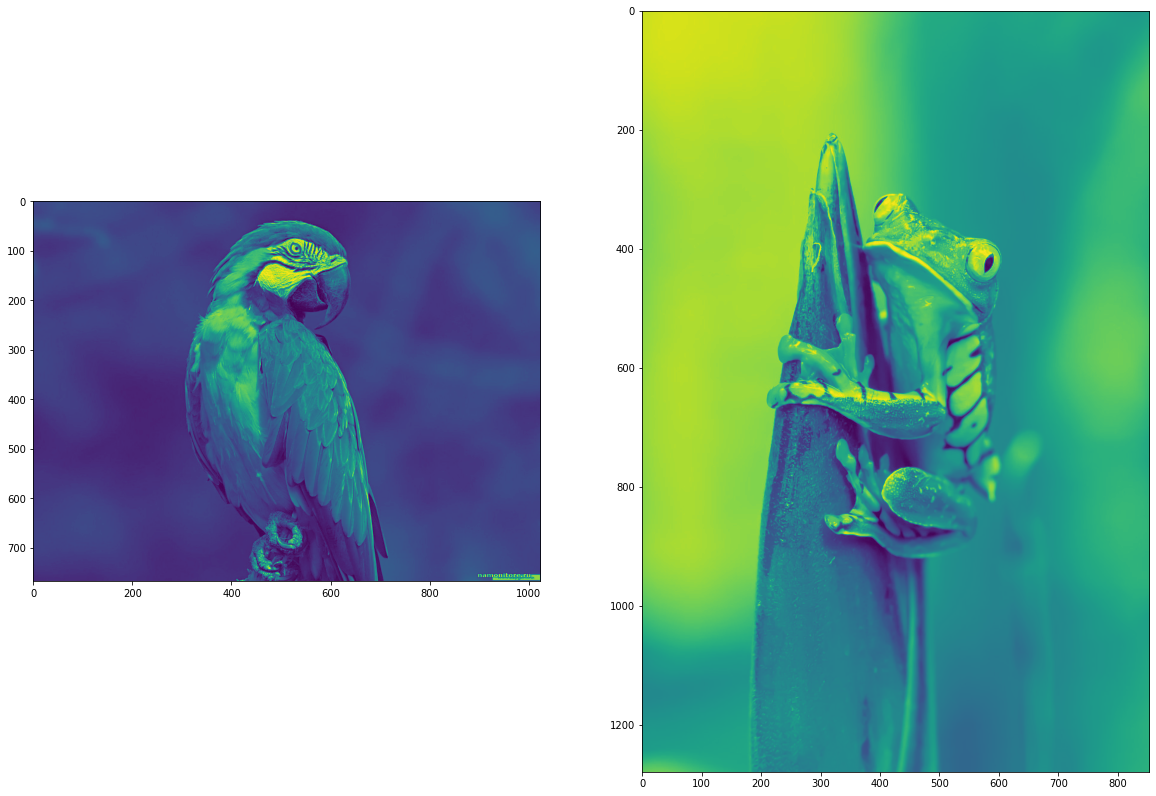

In [ ]:
bird_img = cv2.imread('/content/drive/My Drive/Colab Data/bird.jpg', cv2.IMREAD_GRAYSCALE)
frog_img = cv2.imread('/content/drive/My Drive/Colab Data/frog.jpg', cv2.IMREAD_GRAYSCALE)

fig, ax = plt.subplots(1, 2, figsize=(20, 15))

ax[0].imshow(bird_img)
ax[1].imshow(frog_img)
print(bird_img.shape, frog_img.shape)

Зменшимо розмір зображення

(230, 307) (384, 255)


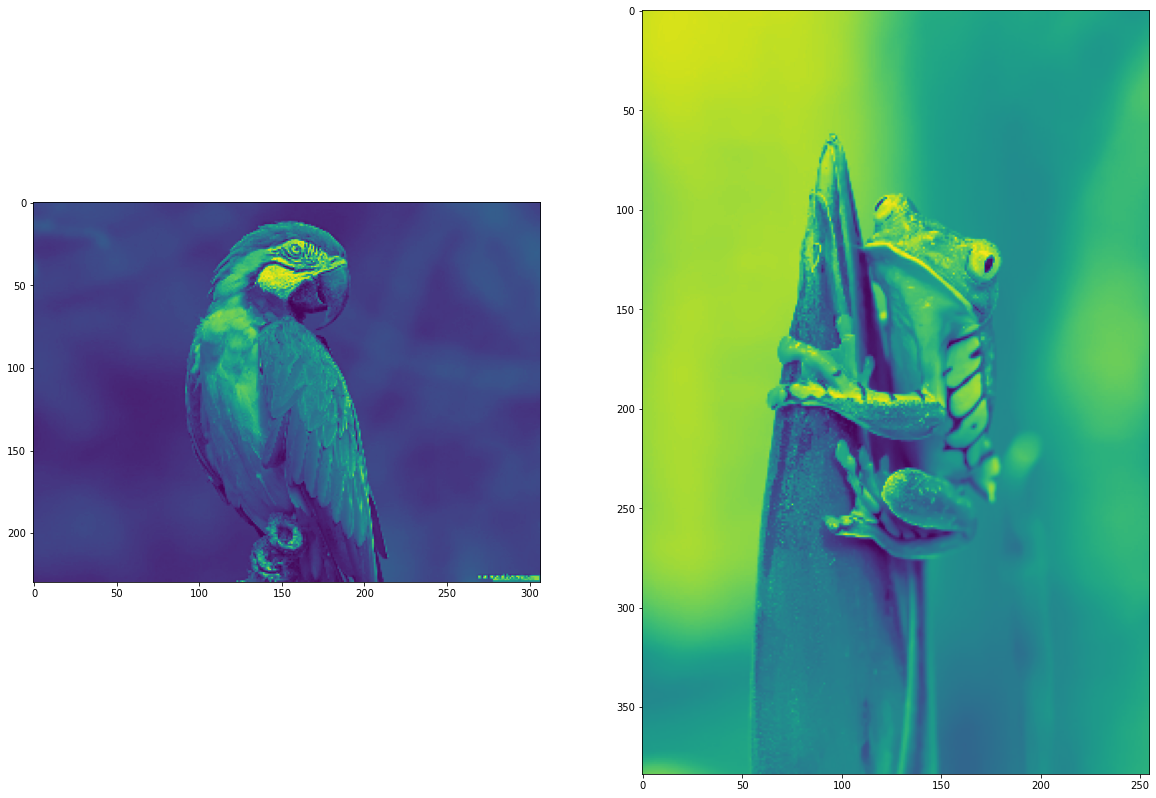

In [ ]:
scale = 0.3
width = int(bird_img.shape[1] * scale)
height = int(bird_img.shape[0] * scale)
bird_img = cv2.resize(bird_img, (width, height))

width = int(frog_img.shape[1] * scale)
height = int(frog_img.shape[0] * scale)
frog_img = cv2.resize(frog_img, (width, height))

fig, ax = plt.subplots(1, 2, figsize=(20, 15))
ax[0].imshow(bird_img)
ax[1].imshow(frog_img)
print(bird_img.shape, frog_img.shape)

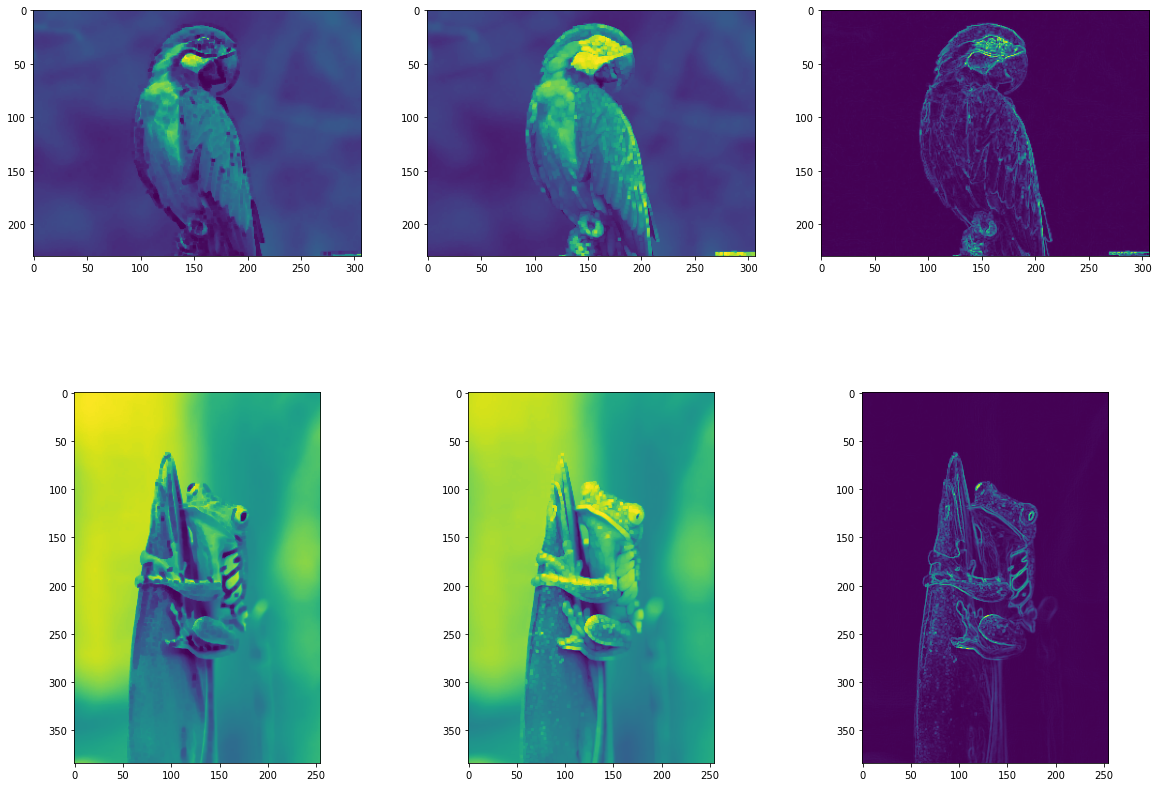

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(20, 15))

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))

bird_erode = cv2.erode(bird_img, kernel, iterations=2)
bird_dilate = cv2.dilate(bird_img, kernel, iterations=2)
bird_morph = cv2.morphologyEx(bird_img, cv2.MORPH_GRADIENT, kernel)

ax[0, 0].imshow(bird_erode)
ax[0, 1].imshow(bird_dilate)
ax[0, 2].imshow(bird_morph)

frog_erode = cv2.erode(frog_img, kernel, iterations=2)
frog_dilate = cv2.dilate(frog_img, kernel, iterations=2)
frog_morph = cv2.morphologyEx(frog_img, cv2.MORPH_GRADIENT, kernel)

ax[1, 0].imshow(frog_erode)
ax[1, 1].imshow(frog_dilate)
ax[1, 2].imshow(frog_morph)

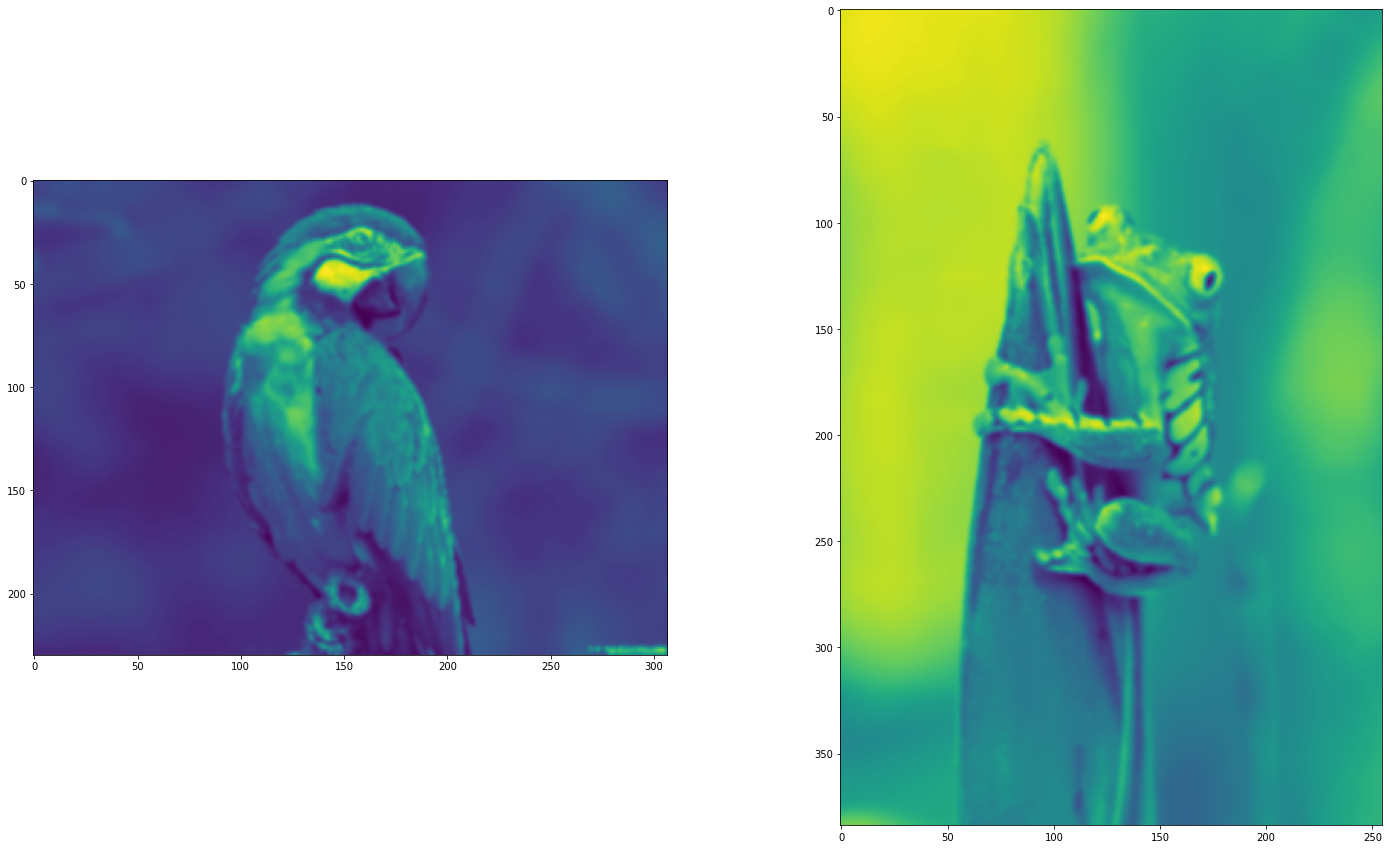

In [ ]:
imgs_gaus = {}

fig, ax = plt.subplots(1, 2, figsize=(25, 15))

bird_gaus = gaussian(bird_img, sigma=1)
frog_gaus = gaussian(frog_img, sigma=1)

ax[0].imshow(bird_gaus)
ax[1].imshow(frog_gaus)

In [ ]:
bird = {'img': bird_img,
        'erode': bird_erode,
        'dilate': bird_dilate,
        'morph': bird_morph,
        'gaus': bird_gaus}

frog = {'img': frog_img,
        'erode': frog_erode,
        'dilate': frog_dilate,
        'morph': frog_morph,
        'gaus': frog_gaus}

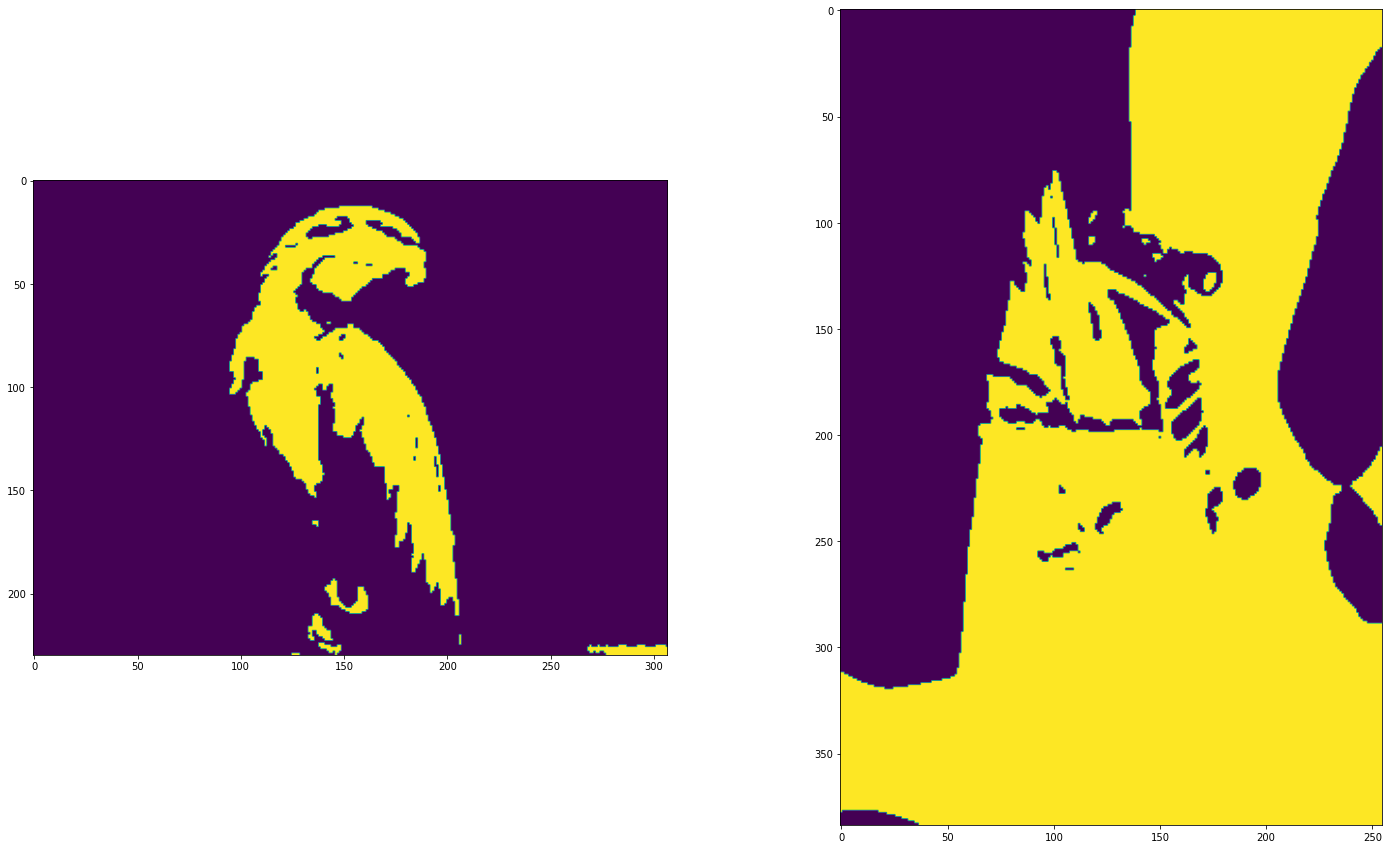

In [ ]:
bird_gaus = (bird_gaus * 255).astype("uint8")
frog_gaus = (frog_gaus * 255).astype("uint8")

bird_threshold, bird_otsu = cv2.threshold(bird_gaus,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
frog_threshold, frog_otsu = cv2.threshold(frog_gaus,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

fig, ax = plt.subplots(1, 2, figsize=(25, 15))
ax[0].imshow(bird_otsu)
ax[1].imshow(frog_otsu)

Далі визначимо кластери для подальшого оцінювання під час навчання кластеризації.

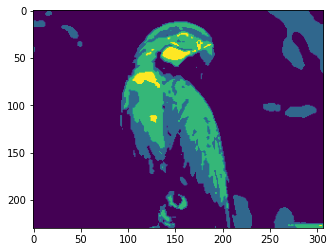

In [ ]:
bird_label = np.zeros_like(bird_img)
bird_label[bird_gaus > 60] = 1
bird_label[bird_gaus > 100] = 2
bird_label[bird_gaus > 180] = 3
plt.imshow(bird_label)

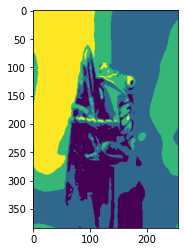

In [ ]:
frog_label = np.zeros_like(frog_img)
frog_label[frog_gaus > 110] = 1
frog_label[frog_gaus > 160] = 2
frog_label[frog_gaus > 210] = 3
plt.imshow(frog_label)

Такий спосіб визначення кластерів не є найкращим, проте для навчальних цілей дуже вдало показує, як працюють деякі алгоритми кластеризації.

In [ ]:
from skimage.metrics import adapted_rand_error, variation_of_information

def metrics(y_true, y_pred):
  err, prec, rec = adapted_rand_error(y_true, y_pred)
  spl, mer = variation_of_information(y_true, y_pred)

  return({
      'Adapted Rand error': err,
      'Adapted Rand precision': prec,
      'Adapted Rand recall': rec,
      'False splits': spl,
      'False merges': mer,
  })

In [ ]:
metrics_bird_df = pd.DataFrame()
metrics_frog_df = pd.DataFrame()

### EM

In [ ]:
from sklearn.mixture import GaussianMixture

def EM(img, true_label):
  vectorized = img.reshape((-1,1))
  model = GaussianMixture(n_components=4,covariance_type='tied').fit(vectorized)
  label = model.predict(vectorized)
  segmented = label.reshape(img.shape[0], img.shape[1])
  
  return segmented, metrics(true_label, segmented)

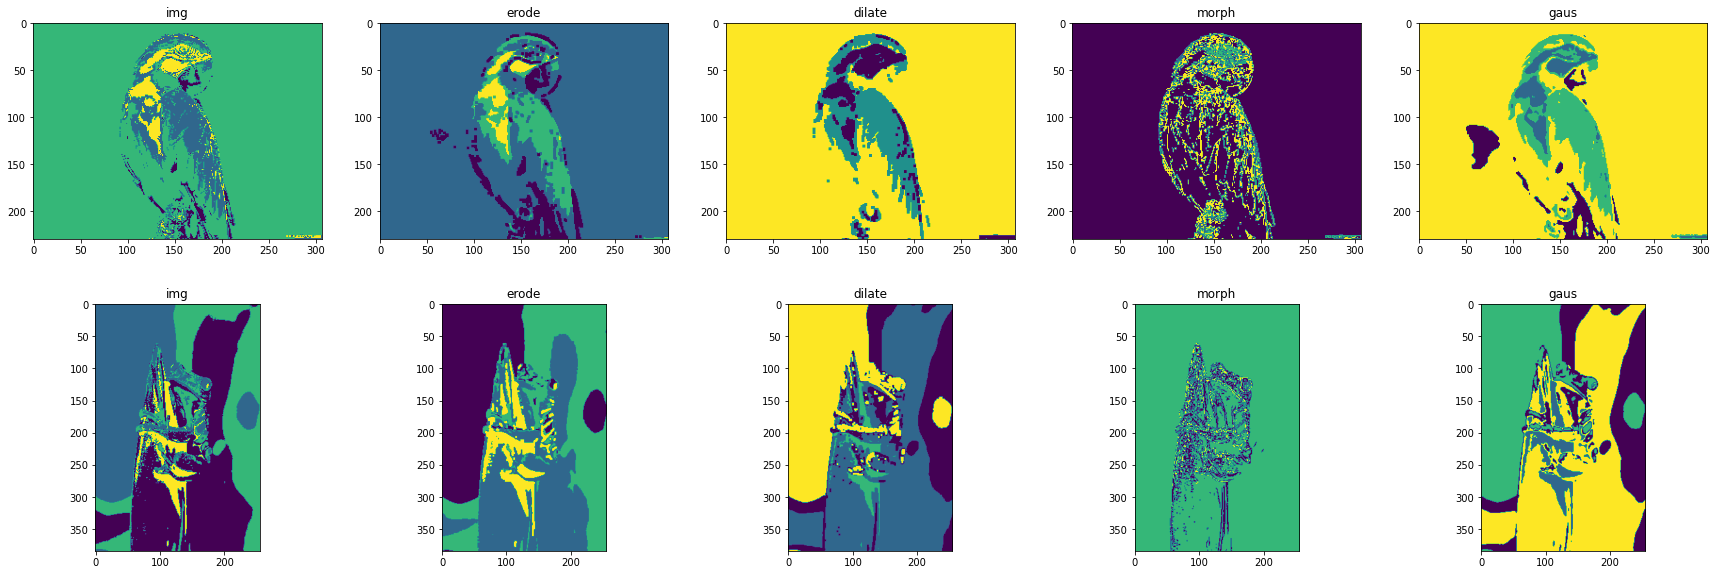

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(30, 10))

for i, metod in enumerate(bird):
  img = bird[metod]
  segment, metric = EM(img, bird_label)
  metrics_bird_df[f'EM, {metod}'] = pd.Series(metric)

  ax[0, i].imshow(segment)
  ax[0, i].set(title = metod)

for i, metod in enumerate(frog):
  img = frog[metod]
  segment, metric = EM(img, frog_label)
  metrics_frog_df[f'EM, {metod}'] = pd.Series(metric)

  ax[1, i].imshow(segment)
  ax[1, i].set(title = metod)

In [ ]:
metrics_bird_df

EM, img  EM, erode  EM, dilate  EM, morph  EM, gaus
Adapted Rand error      0.301560   0.332531    0.399648   0.483719  0.316451
Adapted Rand precision  0.632400   0.621058    0.527165   0.503348  0.625015
Adapted Rand recall     0.779880   0.721378    0.697137   0.529895  0.754179
False splits            0.329860   0.523749    0.306842   0.490788  0.395632
False merges            0.602775   0.724646    0.593295   0.899411  0.545313

In [ ]:
metrics_frog_df

EM, img  EM, erode  EM, dilate  EM, morph  EM, gaus
Adapted Rand error      0.337003   0.390216    0.304540   0.489582  0.256833
Adapted Rand precision  0.628291   0.576587    0.670042   0.823544  0.714222
Adapted Rand recall     0.701761   0.647038    0.722883   0.369809  0.774557
False splits            0.750552   0.884004    0.763832   0.640462  0.639085
False merges            0.879758   0.938320    0.994067   1.844655  0.815662

Відразу проведемо аналіз отриманих результатів. Отже, бачимо, що найкращі результати отримали під час  попередньої обробки задопомогою гауса. Кластеризація в даному випадку має більш суцільні кластери, об'єднавшись у великі групи. Розмиття зображень дозволяє видалити весь наявний шум, що і робить кластеризацію зображення настільки доброю.
Наступними морфологічними операціями є: ерозія та розширення. Вони дозволяють:
- Видалити шум
- Виділити окремі елементи і об'єднати різнорідні елементи в зображені.
- Виявити нерівності в інтенсивності або дірок на зображенні




### Agglomerative clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering

def agglo_cluster(img, true_label):
  vectorized = img.reshape((-1,1))
  model = AgglomerativeClustering(n_clusters=4).fit(vectorized)
  label = model.labels_
  segmented = label.reshape(img.shape[0], img.shape[1])
  
  return segmented, metrics(true_label, segmented)

При застосуванні AgglomerativeClustering виникає проблема в недостатній кількості RAM. Тому для того, щоб продовжити оцінку даного алгоритму зменшимо розмір зображення.

In [ ]:
scale = 0.5
width = int(bird_img.shape[1] * scale)
height = int(bird_img.shape[0] * scale)

bird_label_small = cv2.resize(bird_label, (width, height))

bird_small = {}

for metod in bird:
  bird_small[metod] = cv2.resize(bird[metod], (width, height))

# for frog image
width = int(frog_img.shape[1] * scale)
height = int(frog_img.shape[0] * scale)

frog_label_small = cv2.resize(frog_label, (width, height))

frog_small = {}

for metod in frog:
  frog_small[metod] = cv2.resize(frog[metod], (width, height))

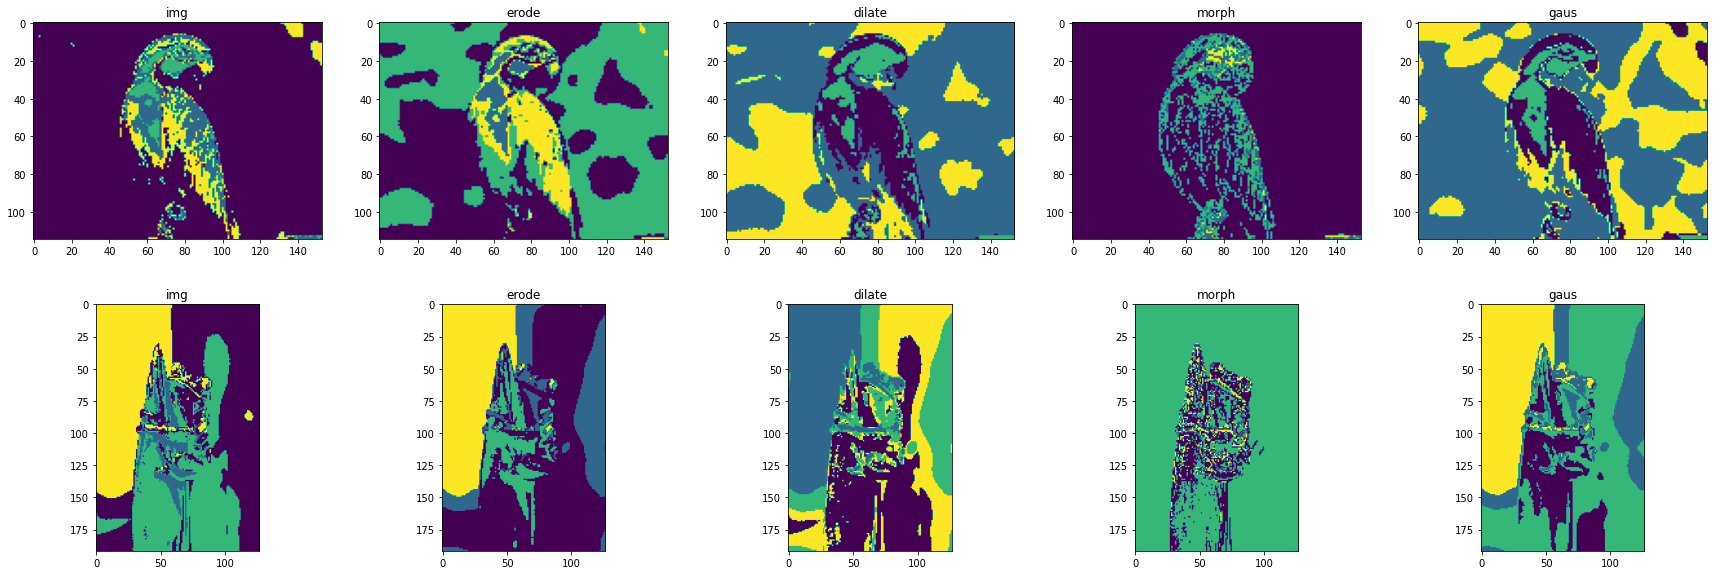

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(30, 10))

for i, metod in enumerate(bird_small):
  img = bird_small[metod]

  segment, metric = agglo_cluster(img, bird_label_small)
  metrics_bird_df[f'Agglomerative {metod}'] = pd.Series(metric)

  ax[0, i].imshow(segment)
  ax[0, i].set(title = metod)

for i, metod in enumerate(frog_small):
  img = frog_small[metod]

  segment, metric = agglo_cluster(img, frog_label_small)
  metrics_frog_df[f'Agglomerative {metod}'] = pd.Series(metric)

  ax[1, i].imshow(segment)
  ax[1, i].set(title = metod)

### Mean shift

In [ ]:
from sklearn.cluster import MeanShift

def mean_shift(img, true_label):
  vectorized = img.reshape((-1,1))
  model = MeanShift().fit(vectorized)
  label = model.predict(vectorized)
  segmented = label.reshape(img.shape[0], img.shape[1])
  
  return segmented, metrics(true_label, segmented)

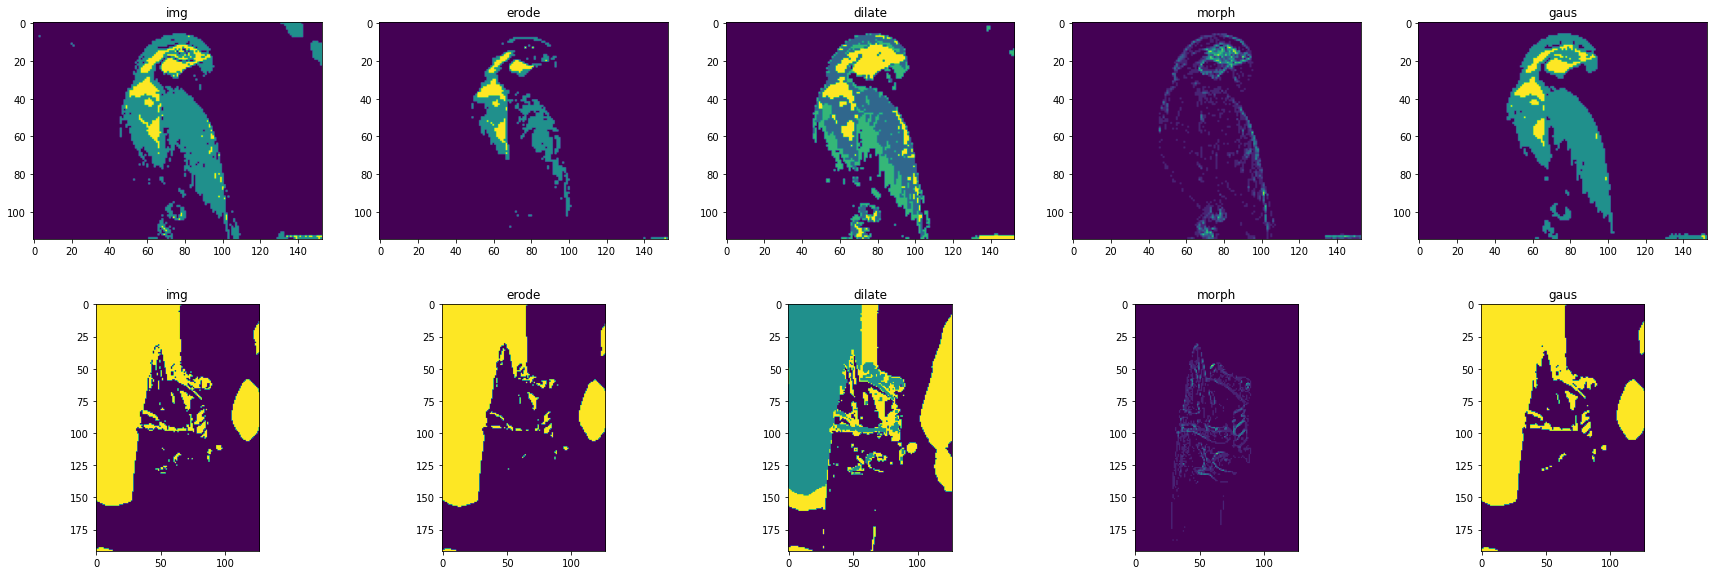

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(30, 10))

for i, metod in enumerate(bird_small):
  img = bird_small[metod]
  segment, metric = mean_shift(img, bird_label_small)
  metrics_bird_df[f'MeanShift, {metod}'] = pd.Series(metric)

  ax[0, i].imshow(segment)
  ax[0, i].set(title = metod)

for i, metod in enumerate(frog_small):
  img = frog_small[metod]
  segment, metric = mean_shift(img, frog_label_small)
  metrics_frog_df[f'MeanShift, {metod}'] = pd.Series(metric)

  ax[1, i].imshow(segment)
  ax[1, i].set(title = metod)

### Fuzzy K-Means

In [ ]:
!pip install fuzzy-c-means

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from fcmeans import FCM

def fuzzy(img, true_label):
  vectorized = img.reshape((-1,1))
  model = FCM(n_clusters=4)
  model.fit(vectorized)
  label = model.predict(vectorized)
  segmented = label.reshape(img.shape[0], img.shape[1])
  
  return segmented, metrics(true_label, segmented)

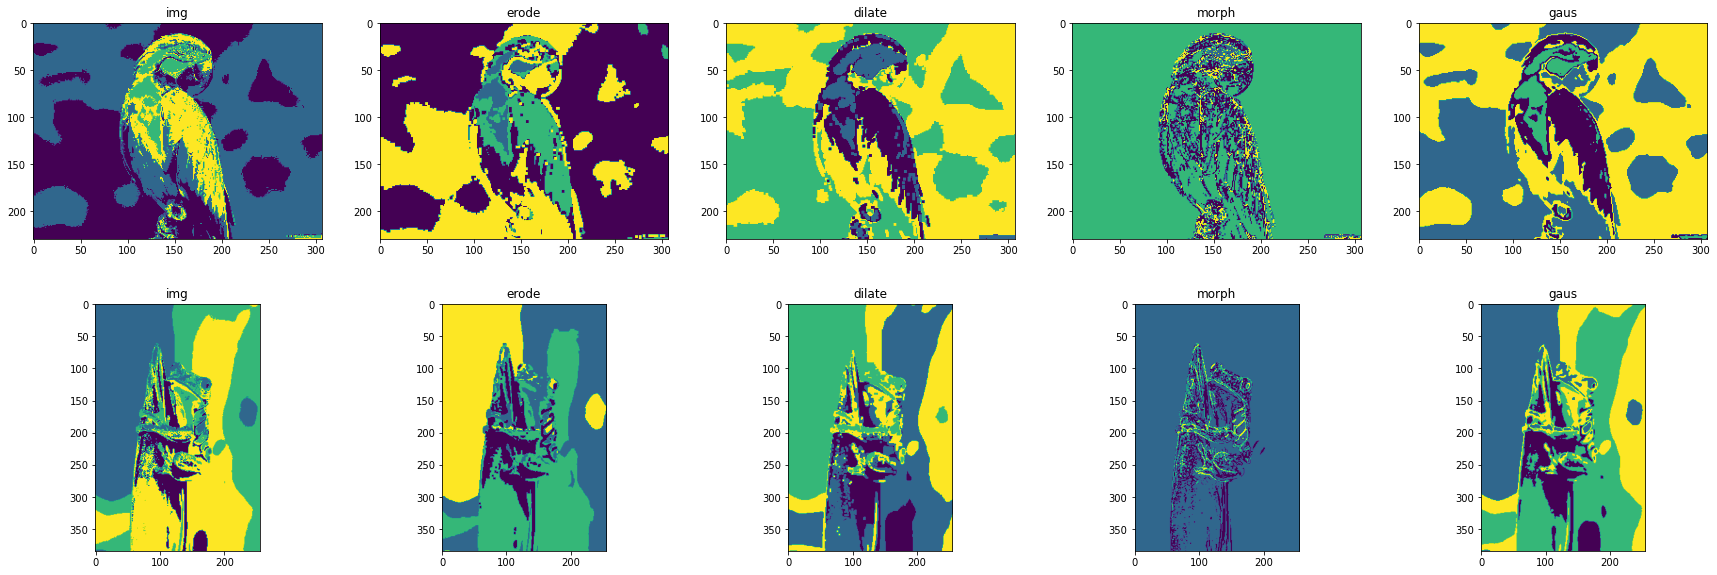

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(30, 10))

for i, metod in enumerate(bird):
  img = bird[metod]
  segment, metric = fuzzy(img, bird_label)
  metrics_bird_df[f'Fuzzy K-Means, {metod}'] = pd.Series(metric)

  ax[0, i].imshow(segment)
  ax[0, i].set(title = metod)

for i, metod in enumerate(frog):
  img = frog[metod]
  segment, metric = fuzzy(img, frog_label)
  metrics_frog_df[f'Fuzzy K-Means, {metod}'] = pd.Series(metric)

  ax[1, i].imshow(segment)
  ax[1, i].set(title = metod)

### K-Means ++

In [ ]:
from sklearn.cluster import KMeans

def kmeans(img, true_label):
  vectorized = img.reshape((-1,1))
  model = KMeans(n_clusters=4, init='k-means++').fit(vectorized)
  label = model.predict(vectorized)
  segmented = label.reshape(img.shape[0], img.shape[1])
  
  return segmented, metrics(true_label, segmented)

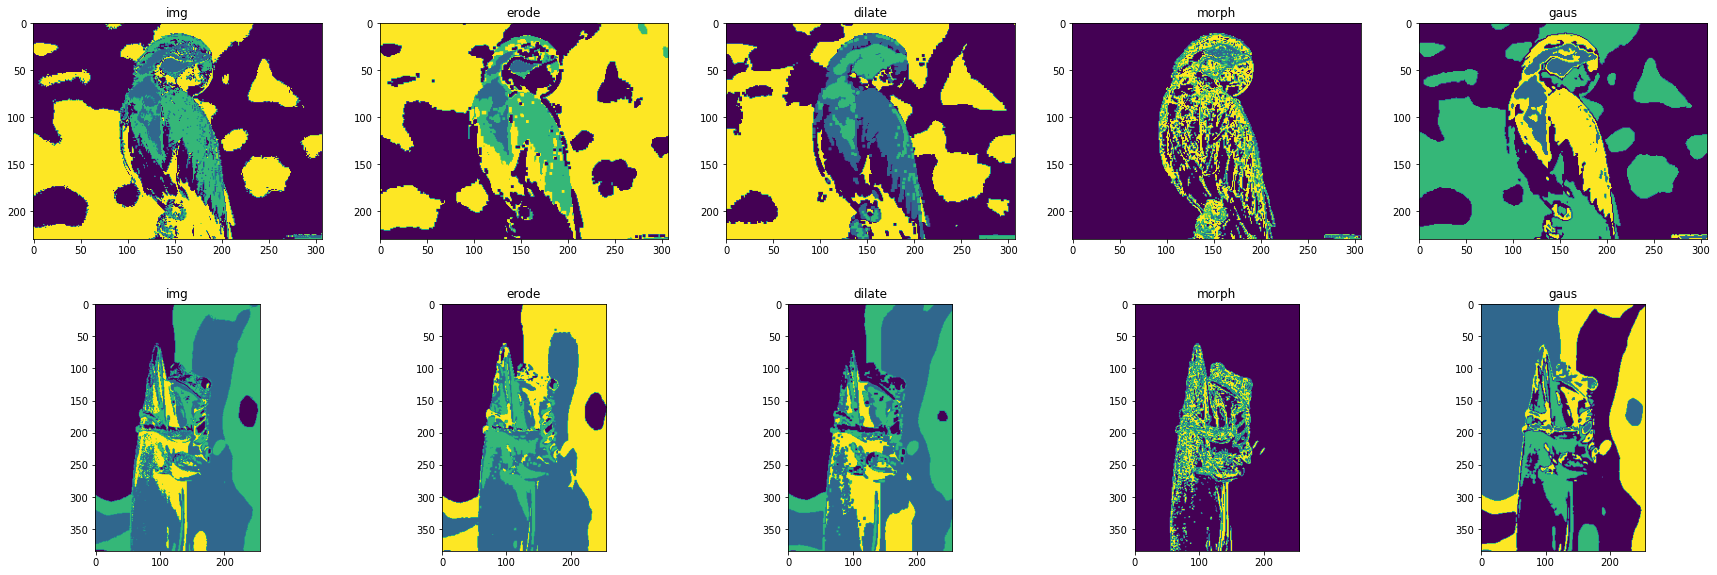

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(30, 10))

for i, metod in enumerate(bird):
  img = bird[metod]
  segment, metric = kmeans(img, bird_label)
  metrics_bird_df[f'KMeans++, {metod}'] = pd.Series(metric)

  ax[0, i].imshow(segment)
  ax[0, i].set(title = metod)

for i, metod in enumerate(frog):
  img = frog[metod]
  segment, metric = kmeans(img, frog_label)
  metrics_frog_df[f'KMeans++, {metod}'] = pd.Series(metric)

  ax[1, i].imshow(segment)
  ax[1, i].set(title = metod)

### Метод росту регіону

In [ ]:
def region_growing(img, seedpoint, mask, threshold, connectivity=1):
  x, y = seedpoint
  mask[x, y] = 1
  mean = np.mean(img[np.where(mask == 1)])

  if y + 1 < img.shape[1] and mask[x, y + 1] == 0:
    if np.abs(mean - img[x, y + 1]) <= threshold:
      region_growing(img, [x, y + 1], mask, threshold)

  if x - 1 >= 0 and mask[x - 1, y] == 0:
    if np.abs(mean - img[x - 1, y]) <= threshold:
      region_growing(img, [x - 1, y], mask, threshold)

  if x + 1 < img.shape[0] and mask[x + 1, y] == 0:
    if np.abs(mean - img[x + 1, y]) <= threshold:
      region_growing(img, [x + 1, y], mask, threshold)

  if y - 1 >= 0 and mask[x, y - 1] == 0:
    if np.abs(mean - img[x, y - 1]) <= threshold:
      region_growing(img, [x, y - 1], mask, threshold)

  if connectivity == 2:

    if y + 1 < img.shape[1] and x - 1 >= 0 and  mask[x - 1, y + 1] == 0:
      if np.abs(mean - img[x - 1, y + 1]) <= threshold:
        region_growing(img, [x - 1, y + 1], mask, threshold)

    if y + 1 < img.shape[1] and x + 1 < img.shape[0] and mask[x + 1, y + 1] == 0:
      if np.abs(mean - img[x + 1, y + 1]) <= threshold:
        region_growing(img, [x + 1, y + 1], mask, threshold)
    
    if y - 1 >= 0 and x - 1 >= 0 and mask[x - 1, y - 1] == 0:
      if np.abs(mean - img[x - 1, y - 1]) <= threshold:
        region_growing(img, [x - 1, y - 1], mask, threshold)

    if y - 1 >= 0 and x + 1 < img.shape[0] and mask[x + 1, y - 1] == 0:
      if np.abs(mean - img[x + 1, y - 1]) <= threshold:
        region_growing(img, [x + 1, y - 1], mask, threshold)

      
  return mask  

[Text(0.5, 1.0, 'img')]

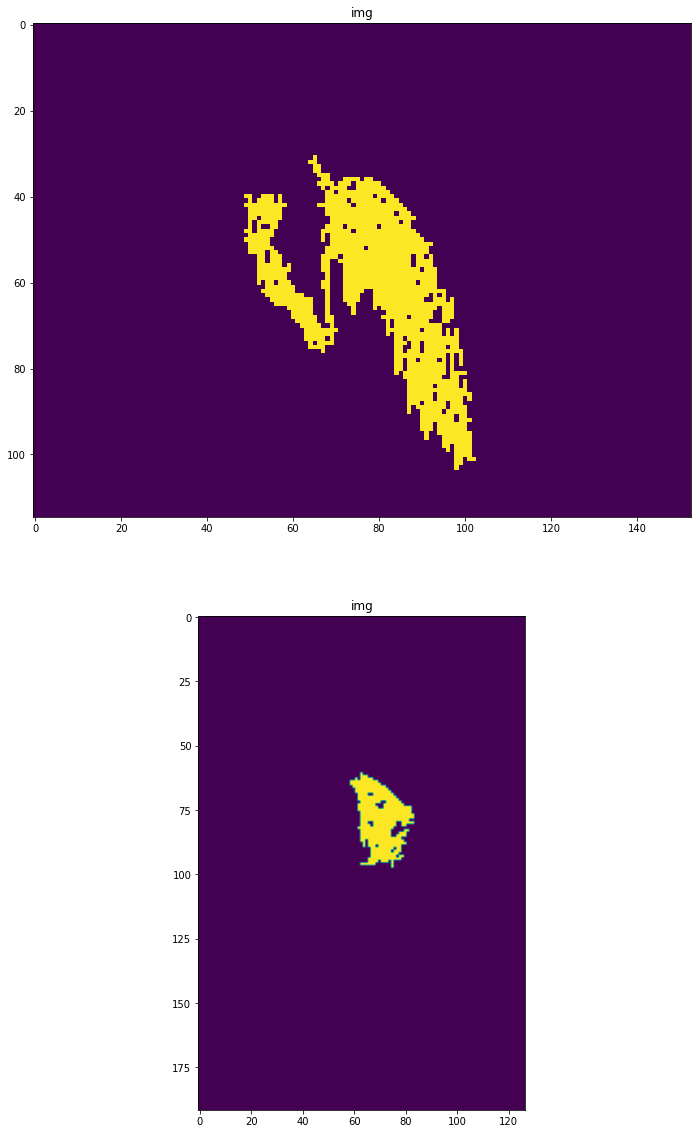

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(30, 20))

img = bird_small['img']

mask = np.zeros_like(img)
x, y = img.shape[0] // 2, img.shape[1] // 2 
segmented = region_growing(img, [x, y], mask, 30)
metric = metrics(bird_label_small, segmented)

metrics_bird_df['Region Growing, img'] = pd.Series(metric)

ax[0].imshow(segmented)
ax[0].set(title = 'img')


img = frog_small['img']

mask = np.zeros_like(img)
x, y = img.shape[0] // 2, img.shape[1] // 2 
segmented = region_growing(img, [x, y], mask, 36)
metric = metrics(frog_label_small, segmented)

metrics_frog_df['Region Growing, img'] = pd.Series(metric)

ax[1].imshow(segmented)
ax[1].set(title = 'img')

При роботі із алгоритмом методу росту регіону можна визначити доволі невелику частину зображення. Тому що виникає помилка `RecursionError: maximum recursion depth exceeded in comparison`. Для ситуації із параметром connectivity=2 ситуація ще гірша. Але дана проблема вирішується додаванням ще однієї початкової точки, що і допоможе виправити проблелму і покращити алгоритм.

### Grab cut

In [ ]:
def grab_cut(img, rect):
  mask = np.zeros(img.shape[:2], np.uint8)
  fgModel = np.zeros((1, 65), dtype="float")
  bgModel = np.zeros((1, 65), dtype="float")
  cv2.grabCut(img, mask, rect, bgModel, fgModel, 5, cv2.GC_INIT_WITH_RECT)
  mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
  output = img*mask2[:,:,np.newaxis]

  return mask, mask2, output

In [ ]:
bird_img = cv2.imread('/content/drive/My Drive/Colab Data/bird.jpg')
frog_img = cv2.imread('/content/drive/My Drive/Colab Data/frog.jpg')

bird_img = cv2.cvtColor(bird_img, cv2.COLOR_BGR2RGB)
frog_img = cv2.cvtColor(frog_img, cv2.COLOR_BGR2RGB)

scale = 0.3
width = int(bird_img.shape[1] * scale)
height = int(bird_img.shape[0] * scale)
bird_img = cv2.resize(bird_img, (width, height))

width = int(frog_img.shape[1] * scale)
height = int(frog_img.shape[0] * scale)
frog_img = cv2.resize(frog_img, (width, height))

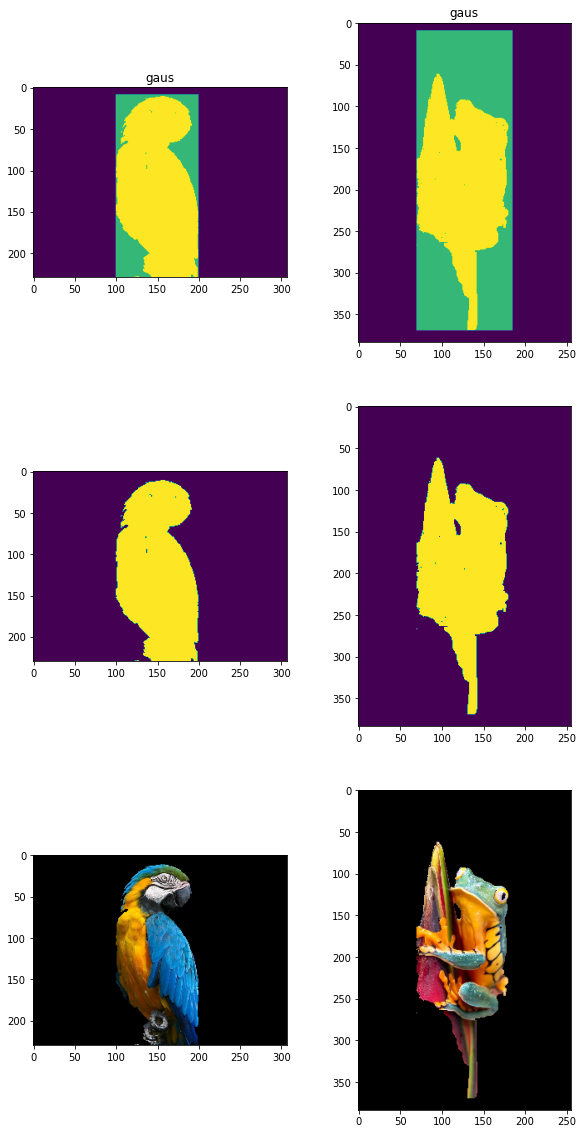

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(10, 20))

mask, mask2, segmented = grab_cut(bird_img, rect=(100,10,100,220))

metric = metrics(bird_label, mask2)
metrics_bird_df['Grub Cut, img'] = pd.Series(metric)

ax[0, 0].imshow(mask)
ax[0, 0].set(title = metod)
ax[1, 0].imshow(mask2)
ax[2, 0].imshow(segmented)

mask, mask2, segmented = grab_cut(frog_img, rect=(70,10,115,360))

metric = metrics(frog_label, mask2)
metrics_frog_df['Grub Cut, img'] = pd.Series(metric)

ax[0, 1].imshow(mask)
ax[0, 1].set(title = metod)
ax[1, 1].imshow(mask2)
ax[2, 1].imshow(segmented)

### Watershed

In [ ]:
bird.pop('gaus')
frog.pop('gaus')

array([[0.91601422, 0.91735691, 0.91862811, ..., 0.55069722, 0.55298883,
        0.55456127],
       [0.91809537, 0.91897662, 0.9201555 , ..., 0.55288069, 0.55549194,
        0.55751495],
       [0.9203032 , 0.92074477, 0.92167337, ..., 0.5560669 , 0.55869268,
        0.56054311],
       ...,
       [0.72413373, 0.72767708, 0.73166493, ..., 0.63337329, 0.63501223,
        0.63597986],
       [0.74068936, 0.74380584, 0.74747237, ..., 0.63400417, 0.63581233,
        0.63717771],
       [0.75241582, 0.75523139, 0.75886047, ..., 0.63424129, 0.63616366,
        0.63785736]])

In [ ]:
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi

def water_shed(img):
  thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
  distance = ndi.distance_transform_edt(thresh)
  coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=thresh)
  mask = np.zeros(distance.shape, dtype=bool)
  mask[tuple(coords.T)] = True
  markers, _ = ndi.label(mask)
  labels = watershed(-distance, markers, mask=thresh)

  return labels

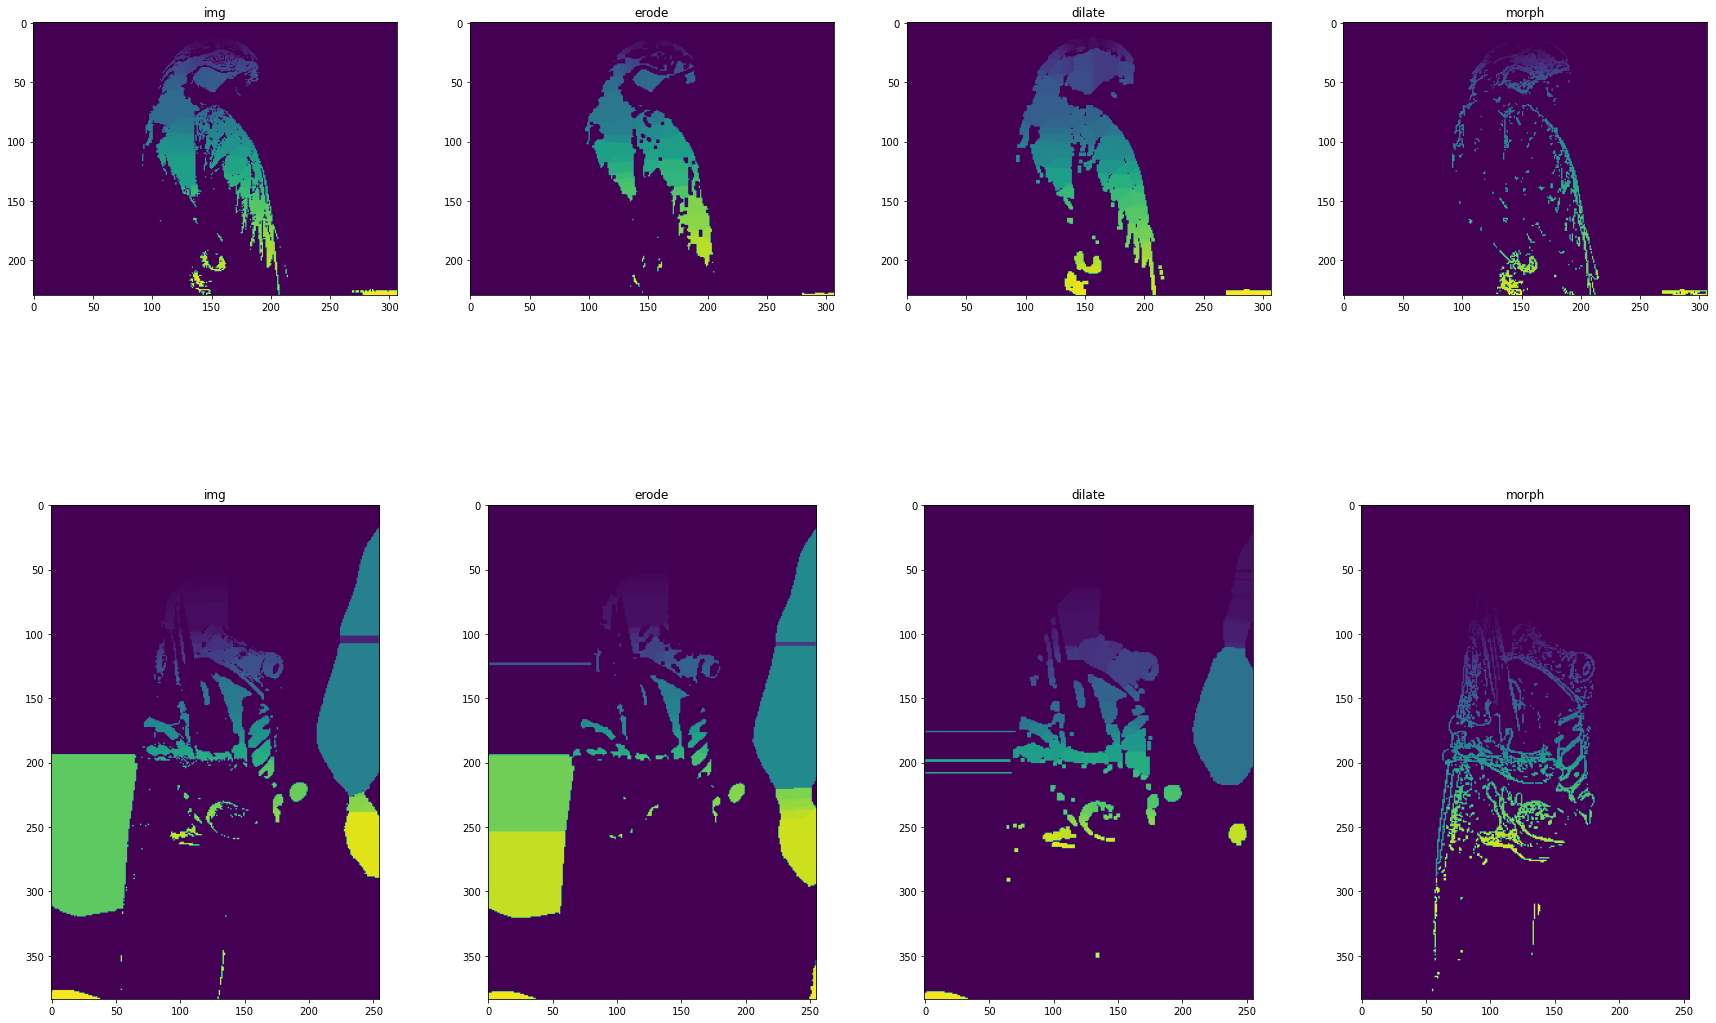

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(30, 20))

for i, metod in enumerate(bird):
  img = bird[metod]
  segment = water_shed(img)
  metric = metrics(bird_label, segment)
  metrics_bird_df[f'watershed, {metod}'] = pd.Series(metric)

  ax[0, i].imshow(segment)
  ax[0, i].set(title = metod)

for i, metod in enumerate(frog):
  img = frog[metod]
  segment = water_shed(img)
  metric = metrics(frog_label, segment)
  metrics_frog_df[f'watershed, {metod}'] = pd.Series(metric)

  ax[1, i].imshow(segment)
  ax[1, i].set(title = metod)

### Flood fill

In [ ]:
def flood_fill(img, seed, dx=120, dy=80):
  mask = np.zeros((img.shape[0] + 2, img.shape[1] + 2), np.uint8)
  floodflags = 4
  floodflags |= cv2.FLOODFILL_FIXED_RANGE
  _, im, res, _ =  cv2.floodFill(img.copy(), mask, seed, (255, 0, 0), (dx,)*3, (dy,)*3, floodflags)
  segmented = cv2.resize(res, (mask.shape[1] - 2, mask.shape[0] - 2))
  
  return segmented

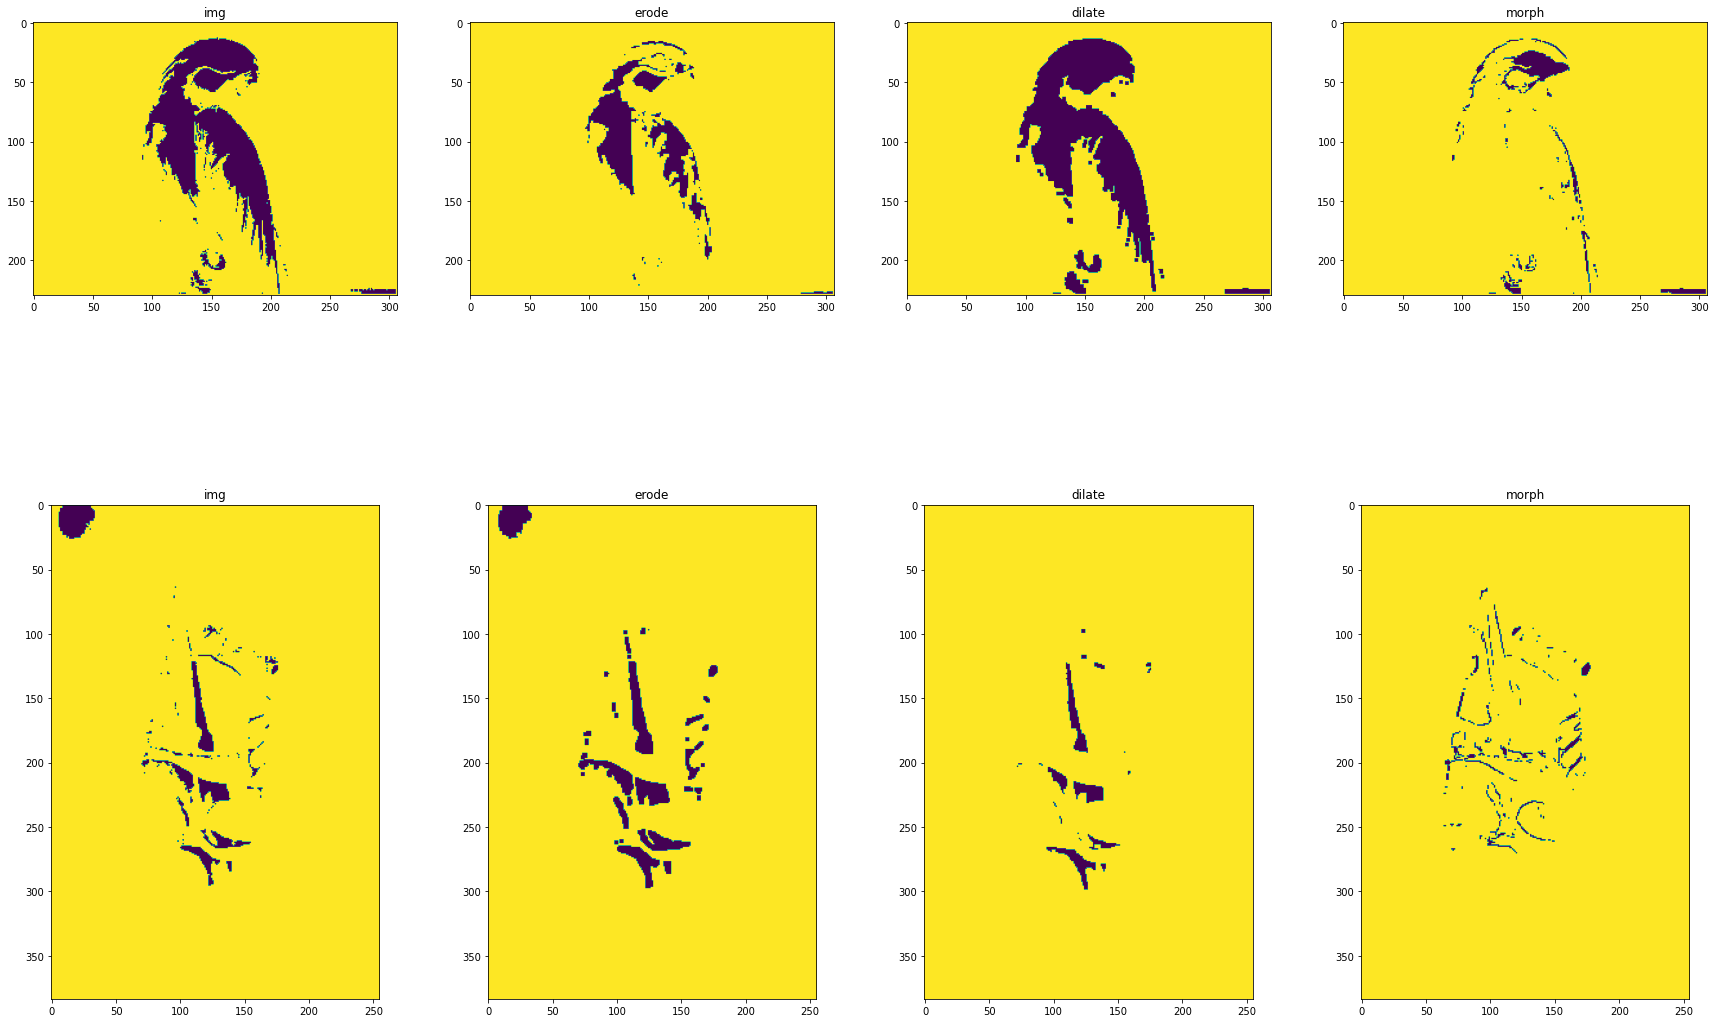

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(30, 20))

for i, metod in enumerate(bird):
  img = bird[metod]
  segment = flood_fill(img, (150, 150))
  metric = metrics(bird_label, segment)
  metrics_bird_df[f'Flood fill, {metod}'] = pd.Series(metric)

  ax[0, i].imshow(segment)
  ax[0, i].set(title = metod)

for i, metod in enumerate(frog):
  img = frog[metod]
  segment = flood_fill(img, (150, 150))
  metric = metrics(frog_label, segment)
  metrics_frog_df[f'Flood fill, {metod}'] = pd.Series(metric)

  ax[1, i].imshow(segment)
  ax[1, i].set(title = metod)

In [ ]:
metrics_bird_df.T

Adapted Rand error  Adapted Rand precision  \
EM, img                          0.301560                0.632400   
EM, erode                        0.332531                0.621058   
EM, dilate                       0.399648                0.527165   
EM, morph                        0.483719                0.503348   
EM, gaus                         0.316451                0.625015   
Agglomerative img                0.390739                0.485437   
Agglomerative erode              0.436690                0.473778   
Agglomerative dilate             0.460138                0.488695   
Agglomerative morph              0.495920                0.475246   
Agglomerative gaus               0.447418                0.520972   
MeanShift, img                   0.424922                0.565504   
MeanShift, erode                 0.277402                0.791389   
MeanShift, dilate                0.462591                0.422699   
MeanShift, morph                 0.459445                0.574714   
MeanShift, gaus                  0.359752                0.624108   
Fuzzy K-Means, img               0.370202                0.549914   
Fuzzy K-Means, erode             0.445698                0.470813   
Fuzzy K-Means, dilate            0.413480                0.511241   
Fuzzy K-Means, morph             0.510699                0.434610   
Fuzzy K-Means, gaus              0.355535                0.580227   
KMeans++, img                    0.380003                0.539033   
KMeans++, erode                  0.436615                0.477886   
KMeans++, dilate                 0.408956                0.514798   
KMeans++, morph                  0.511949                0.432295   
KMeans++, gaus                   0.356150                0.578922   
Region Growing, img              0.458153                0.601852   
Grub Cut, img                    0.437127                0.633414   
watershed, img                   0.352433                0.504932   
watershed, erode                 0.393745                0.525048   
watershed, dilate                0.490771                0.346429   
watershed, morph                 0.422556                0.707177   
Flood fill, img                  0.235543                0.788518   
Flood fill, erode                0.295225                0.816173   
Flood fill, dilate               0.292698                0.736587   
Flood fill, morph                0.383854                0.846356   

                       Adapted Rand recall  False splits  False merges  
EM, img                           0.779880      0.329860      0.602775  
EM, erode                         0.721378      0.523749      0.724646  
EM, dilate                        0.697137      0.306842      0.593295  
EM, morph                         0.529895      0.490788      0.899411  
EM, gaus                          0.754179      0.395632      0.545313  
Agglomerative img                 0.817885      0.281465      0.442786  
Agglomerative erode               0.694566      1.086347      0.680765  
Agglomerative dilate              0.602997      1.039676      0.535944  
Agglomerative morph               0.536639      0.524132      0.883992  
Agglomerative gaus                0.588276      0.884590      0.374918  
MeanShift, img                    0.584982      0.211546      0.508414  
MeanShift, erode                  0.664810      0.144617      0.797331  
MeanShift, dilate                 0.737567      0.443021      0.513200  
MeanShift, morph                  0.510230      0.447579      0.937314  
MeanShift, gaus                   0.657245      0.171209      0.527349  
Fuzzy K-Means, img                0.736837      1.004841      0.539713  
Fuzzy K-Means, erode              0.673785      1.043919      0.679139  
Fuzzy K-Means, dilate             0.687797      1.078335      0.520135  
Fuzzy K-Means, morph              0.559738      0.604044      0.845632  
Fuzzy K-Means, gaus               0.724696      0.959691      0.469927  
KMean

In [ ]:
metrics_frog_df.T

Adapted Rand error  Adapted Rand precision  \
EM, img                          0.337003                0.628291   
EM, erode                        0.390216                0.576587   
EM, dilate                       0.304540                0.670042   
EM, morph                        0.489582                0.823544   
EM, gaus                         0.256833                0.714222   
Agglomerative img                0.370718                0.620553   
Agglomerative erode              0.142806                0.845664   
Agglomerative dilate             0.349030                0.554858   
Agglomerative morph              0.505095                0.753623   
Agglomerative gaus               0.068050                0.943225   
MeanShift, img                   0.220852                0.924758   
MeanShift, erode                 0.233148                0.921831   
MeanShift, dilate                0.155765                0.832603   
MeanShift, morph                 0.476412                0.884266   
MeanShift, gaus                  0.218005                0.929661   
Fuzzy K-Means, img               0.331992                0.630881   
Fuzzy K-Means, erode             0.378903                0.580174   
Fuzzy K-Means, dilate            0.294183                0.674205   
Fuzzy K-Means, morph             0.500451                0.776489   
Fuzzy K-Means, gaus              0.273671                0.690370   
KMeans++, img                    0.333536                0.629764   
KMeans++, erode                  0.385059                0.576322   
KMeans++, dilate                 0.270743                0.699856   
KMeans++, morph                  0.498191                0.786166   
KMeans++, gaus                   0.286942                0.676732   
Region Growing, img              0.463857                0.951855   
Grub Cut, img                    0.494140                0.781682   
watershed, img                   0.161099                0.775408   
watershed, erode                 0.181373                0.769439   
watershed, dilate                0.213611                0.783465   
watershed, morph                 0.473063                0.903224   
Flood fill, img                  0.455578                0.986560   
Flood fill, erode                0.457478                0.982681   
Flood fill, dilate               0.455855                0.998959   
Flood fill, morph                0.459824                0.979372   

                       Adapted Rand recall  False splits  False merges  
EM, img                           0.701761      0.750552      0.879758  
EM, erode                         0.647038      0.884004      0.938320  
EM, dilate                        0.722883      0.763832      0.994067  
EM, morph                         0.369809      0.640462      1.844655  
EM, gaus                          0.774557      0.639085      0.815662  
Agglomerative img                 0.638260      0.715023      0.853089  
Agglomerative erode               0.869043      0.598770      0.753463  
Agglomerative dilate              0.787354      0.870645      0.786642  
Agglomerative morph               0.368425      0.808549      1.805268  
Agglomerative gaus                0.920942      0.260773      0.299171  
MeanShift, img                    0.673155      0.203512      1.173145  
MeanShift, erode                  0.656483      0.214021      1.207753  
MeanShift, dilate                 0.856197      0.417758      0.882070  
MeanShift, morph                  0.371897      0.444723      1.873164  
MeanShift, gaus                   0.674810      0.188448      1.161384  
Fuzzy K-Means, img                0.709777      0.768355      0.812795  
Fuzzy K-Means, erode              0.668230      0.898861      0.913136  
Fuzzy K-Means, dilate             0.740540      0.778760      0.785514  
Fuzzy K-Means, morph              0.368221      0.766112      1.817426  
Fuzzy K-Means, gaus               0.766241      0.660474      0.666160  
KMean

### Висновок
Отже, під час проведення практичного завдання було дослідженно роботу алгоритмів кластеризації і як на ці алгоритми впливають методи попередньої обробки. <br/>
Серед алгоритмів кластеризації маємо два найкращі алгоритми це EM та KMeans++. <br/>
Серед метрик ми маємо: variation_of_information - варіація інформації між двома розділами вузлів. Та adapted_rand_error - обчислює адаптовану помилку Rand серед релевантних метрик precision(також відома як позитивна прогностична цінність) – це частка релевантних екземплярів серед отриманих екземплярів, тоді як recall(також відома як чутливість) – це частка релевантних екземплярів, які отримані. <br/>
При цьому метрики variation_of_information є кращими для порівняння.
